In [9]:
import matplotlib.pyplot as plt
import numpy as np

from math import sqrt, exp, pow
from scipy.stats import norm
from scipy.stats import poisson

In [3]:
"""
brownian() implements one dimensional Brownian motion (i.e. the Wiener process).
"""

def brownian(x0, n, dt, delta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

In [4]:
# Set up the paramaters
_mu      = 0.03 
_beta0   = -5/16
_beta1   = 1/8
_alpha   = -1/40
_rho     = -0.3

In [385]:
N = 23400

# Simulate:
for i in range(1,10):

    # (1) Generate the Poissont realization:
    #_lambda = (3,6)
    #l1 = poisson.rvs(_lambda[1], size=1)
    
    t = np.linspace(0.0, 1.0, N)
    dt = t[2]-t[1]
    
    # Generate the brownian motion:
    bm_dB = brownian(norm.rvs(size=1), N, dt, 1)
    bm_dW = brownian(norm.rvs(size=1), N, dt, 1)
    
    # Estimate the process:
    gamma = np.zeros(t.size)
    sigma = np.zeros(t.size)
    F     = np.zeros(t.size)
    V     = np.zeros(t.size)
    Y1    = np.zeros(t.size)
    Y2    = np.zeros(t.size)
    
    #c0 = (norm.rvs(0, sqrt(-1/(2.0*_alpha)), size=1) + bm_dB[0][0]/_alpha)
    gamma[0] = norm.rvs(0, sqrt(-1/(2.0*_alpha)), size=1)
    sigma[0] = exp(_beta0 + _beta1*gamma[0])
    F[0]     = dF_i(_rho, sigma[0], bm_dW[0][0])
    V[0]     = dV_i(_rho, sigma[0], bm_dB[0][0])
    Y1[0]    = dY_i(_mu, V[0], dF[0])
    for j in range(1,N):
        dB_j     = bm_dB[0][j] - bm_dB[0][j-1]
        dW_j     = bm_dW[0][j] - bm_dW[0][j-1]
        gamma[j] = gamma[j-1] + (_alpha*gamma[j-1]*dt + dB_j)
        #gamma[j] = c0*exp(_alpha*t[j]) #- dB_j/_alpha
        sigma[j] = exp(_beta0 + _beta1*gamma[j])
    
    sigma = sigma/np.sum(sigma)
    
    for j in range(1,N):
        F[j]     = sqrt(1-pow(_rho, 2.0)) * sigma[j] * dW_j
        V[j]     = _rho * sigma[j] * dB_j
        Y1[j]     = Y[j-1] + (_mu*dt + _rho*sigma[j]*dB_j + sqrt(1-pow(_rho, 2.0))*sigma[j]*dW_j)
        
    U = norm.rvs(0, np.sum(np.power(sigma, 4))/N, size=N)
    Y1 = Y1 + U
     
    #c0 = (norm.rvs(0, sqrt(-1/(2.0*_alpha)), size=1) + bm_dB[0][0]/_alpha)
    gamma[0] = norm.rvs(0, sqrt(-1/(2.0*_alpha)), size=1)
    sigma[0] = exp(_beta0 + _beta1*gamma[0])
    F[0]     = dF_i(_rho, sigma[0], bm_dW[0][0])
    V[0]     = dV_i(_rho, sigma[0], bm_dB[0][0])
    Y1[0]    = dY_i(_mu, V[0], dF[0])
    for j in range(1,N):
        dB_j     = bm_dB[0][j] - bm_dB[0][j-1]
        dW_j     = bm_dW[0][j] - bm_dW[0][j-1]
        gamma[j] = gamma[j-1] + (_alpha*gamma[j-1]*dt + dB_j)
        #gamma[j] = c0*exp(_alpha*t[j]) #- dB_j/_alpha
        
    sigma = sigma/np.sum(sigma)
    
    for j in range(1,N):
        sigma[j] = exp(_beta0 + _beta1*gamma[j])
        F[j]     = sqrt(1-pow(_rho, 2.0)) * sigma[j] * dW_j
        V[j]     = _rho * sigma[j] * dB_j
        Y2[j]     = Y[j-1] + (_mu*dt + _rho*sigma[j]*dB_j + sqrt(1-pow(_rho, 2.0))*sigma[j]*dW_j)
        
    U = norm.rvs(0, np.sum(np.power(sigma, 4))/N, size=N)
    Y2 = Y2 + U
        

In [386]:
exp(-2*_beta1**2/_alpha)-1

2.4903429574618414

In [387]:
np.var(np.power(sigma,2))

0.00020195809863900586

In [388]:
np.corrcoef(np.vstack((Y[1:N-1]-Y[0:N-2], gamma[1:N-1]-gamma[0:N-2])))

array([[  1.00000000e+00,  -1.07231970e-04],
       [ -1.07231970e-04,   1.00000000e+00]])

In [389]:
np.corrcoef(np.vstack((Y1, Y2)))

array([[ 1.        ,  0.97233267],
       [ 0.97233267,  1.        ]])

In [390]:
1-pow(_rho, 2.0)

0.91

In [391]:
gamma[0]

-4.493196182872679

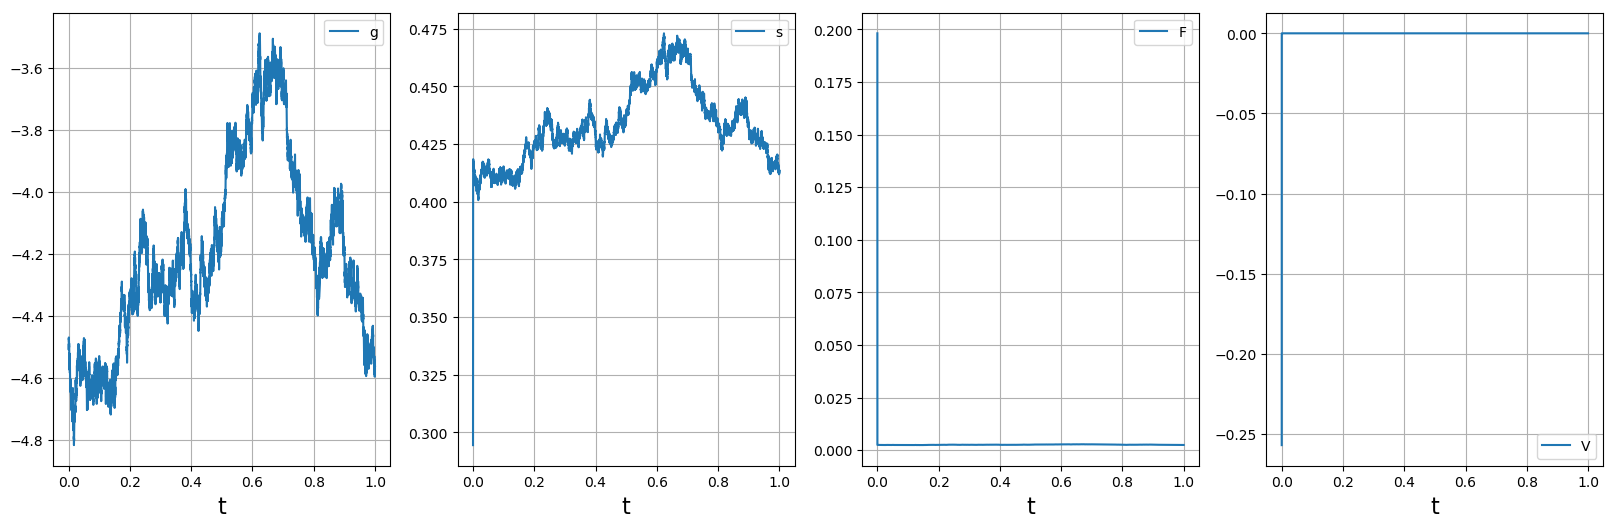

In [392]:
from pylab import plot, show, grid, xlabel, ylabel, subplot, figure, legend

figure(figsize=(20, 6), dpi=100)
subplot(1,4,1)
plot(t, np.transpose(gamma))
xlabel('t', fontsize=16)
legend(labels=("gamma"))
grid(True)
subplot(1,4,2)
plot(t, np.transpose(sigma))
xlabel('t', fontsize=16)
legend(labels=("sigma"))
grid(True)
subplot(1,4,3)
plot(t, np.transpose(F))
xlabel('t', fontsize=16)
legend(labels=("F"))
grid(True)
subplot(1,4,4)
plot(t, np.transpose(V))
xlabel('t', fontsize=16)
legend(labels=("V"))
grid(True)
show()

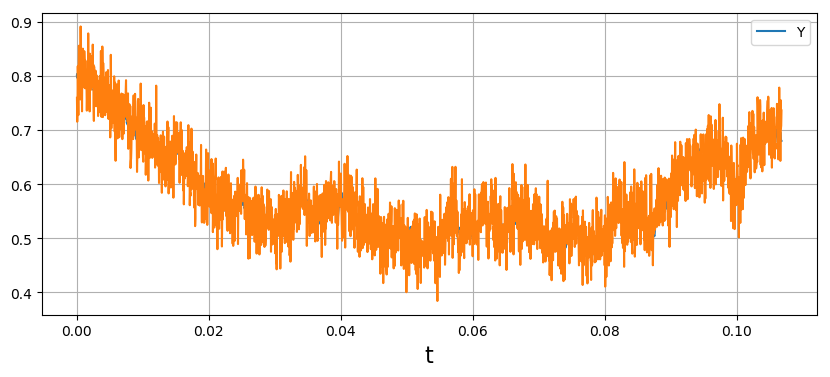

In [393]:
figure(figsize=(10, 4), dpi=100)
plot(t[1:2500], np.transpose(Y1[1:2500]))
plot(t[1:2500], np.transpose(Y2[1:2500]))
xlabel('t', fontsize=16)
legend(labels=("Y"))
grid(True)
show()